---
title: "머신러닝 알고리즘 - LightGbm"
date: 2020-07-16T18:00:47+09:00
tags:
  - "머신러닝"
  - "Python"
  - "Machine Learning"
categories:
  - "머신러닝"
  - "Python"
  - "Machine Learning"
menu: 
  kaggle:
    name: 머신러닝 알고리즘 - LightGbm
---


## 개요
- 주택가격을 예측하는 데 필요한 Kaggle 데이터를 불러와서 빅쿼리에 저장하는 실습 진행
- 데이터를 불러와서 `LightGBM`를 활용하여 머신러닝을 만든다. 

## I. 사전 준비작업
- `Kaggle API` 설치 및 연동해서 `GCP`에 데이터를 적재하는 것까지 진행한다. 

### (1) Kaggle API 설치
- 구글 코랩에서 `API`를 불러오려면 다음 소스코드를 실행한다. 

In [ ]:
!pip install kaggle

### (2) Kaggle Token 다운로드
- Kaggle에서 API Token을 다운로드 받는다.
- [Kaggle]-[My Account]-[API]-[Create New API Token]을 누르면 `kaggle.json` 파일이 다운로드 된다.
- 이 파일을 바탕화면에 옮긴 뒤, 아래 코드를 실행 시킨다.

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# kaggle.json을 아래 폴더로 옮긴 뒤, file을 사용할 수 있도록 권한을 부여한다. 
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
uploaded file "kaggle.json" with length 64 bytes


- 실제 `kaggle.json` 파일이 업로드 되었다는 뜻이다. 

In [ ]:
ls -1ha ~/.kaggle/kaggle.json

/root/.kaggle/kaggle.json


### (3) Kaggle 데이터 불러오기
- `Kaggle` 대회 리스트를 불러온다. 

In [ ]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        221           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         38           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        354           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2671           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      19492            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       5160            True  
connectx

- 여기에서 참여하기 원하는 대회의 데이터셋을 불러오면 된다.
- 이번 `basic`강의에서는 `house-prices-advanced-regression-techniques` 데이터를 활용한 데이터 가공과 시각화를 연습할 것이기 때문에 아래와 같이 코드를 실행하여 데이터를 불러온다.

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 66.0MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 12.9MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 62.4MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 31.6MB/s]


- 실제 데이터가 잘 다운로드 받게 되었는지 확인한다.

In [ ]:
!ls

data_description.txt  sample_data  sample_submission.csv  test.csv  train.csv


### (4) 데이터 불러오기
- `pandas` 모듈을 활용해서 데이터를 확인해본다. 

In [ ]:
import pandas as pd
data = pd.read_csv('train.csv')
print(data.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## II. 회귀 모형 개요
- 회귀(Regression)은 통계 이론 중 가장 기본이다. 
- 회귀의 기원은 영국의 통계학자 갈톤(Galton)이 수행한 연구에서 유래한다. 

![](https://miro.medium.com/max/624/1*A6lmiVPlGM-Y4A6exdf17Q.png)

- 부모와 자식 간의 키의 상관관계를 분석하였는데, 키가 작은 가정과 키가 큰 가정을 살펴본 결과, 무한정 작아지지도 않고, 무한정 커지지 않아 일정한 평균으로 회귀하려는 자연적 법칙을 발견했다는 것이 기원이다. 


### (1) 회귀식의 개요
- 회귀는 1차 방정식이다. 
  + 지역, 방의 면적, 크기 등 여러 개의 독립변수에 따라 아파트 가격이라는 종속변수가 어떠한 관계를 나타내는지를 예측하고 모델링하는 것
  + 즉, 수치를 예측할 때 사용한다. 

$$ Y = X_{1}\times W_{1} + X_{2}\times X_{2} + X_{3}\times W_{3} + \cdot \cdot \cdot + X_{n}\times W_{n}  $$

- 위 회귀식을 간단히 설명하면 다음과 같다. 
  + Y = 종속변수가 되며, 본 데이터에서는 `SalePrice`에 해당된다. 
  + $X_{1}$, $X_{2}$, $X_{3}$, $\cdot\cdot\cdot$, $X_{n}$은 지역, 방의 면적, 크기 등의 독립변수를 의미한다. 
  + $W_{1}$, $W_{2}$, $W_{3}$, $\cdot\cdot\cdot$, $W_{n}$은 회귀의 계수 등을 의미한다. 
  + 즉, 최적의 회귀 계수를 찾아가는 것이 회귀모형의 핵심이다. 
- 간단한 예제를 통해 확인해보자. 


In [14]:
import pandas as pd
from sklearn.datasets import load_boston

boston_raw = load_boston()
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    return df

df_boston = sklearn_to_df(boston_raw)
df_boston.shape

(506, 14)

In [2]:
df_boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


- 각 데이터 변수에 대한 설명서를 제공하고 있다. 

In [3]:
print(boston_raw.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [15]:
df_boston = df_boston.rename({"target": "MEDV"}, axis='columns')

- 간단하게 시각화를 진행한다. 

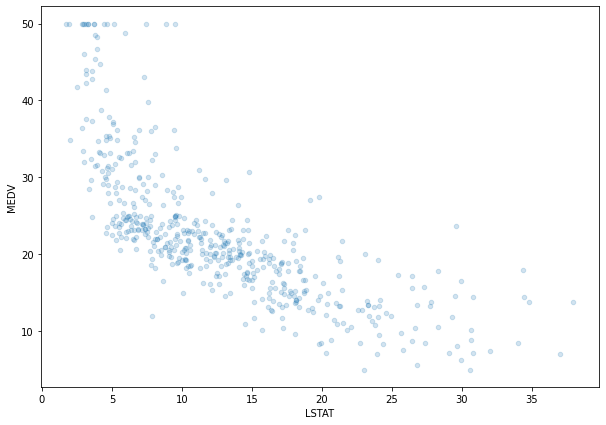

In [5]:
import matplotlib.pyplot as plt
df_boston.plot(kind = "scatter", x = "LSTAT", y = "MEDV", alpha = 0.2, figsize = (10, 7))

- `MEDV`는 평균 값을 의미하며, 우리가 예측하려는 데이터와 같다. 
- 그런데, 데이터는 이렇게 변수 2개로 설명되는 일이 드물다. 
- 위 데이터에서 `cmap()`을 `AGE` 변수를 추가하여 색상의 변동을 확인해보자. 

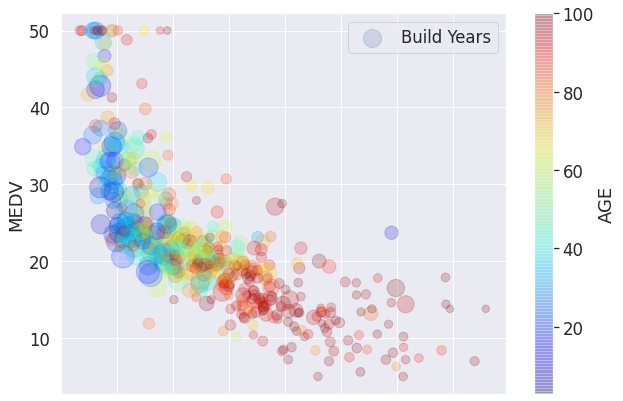

In [16]:
df_boston.plot(kind = "scatter", 
               x = "LSTAT", 
               y = "MEDV", 
               alpha = 0.2, 
               label = 'Build Years', 
               s = df_boston['DIS'] * 50, 
               c = "AGE", 
               figsize = (10, 7),
               cmap = plt.get_cmap('jet'), colorbar = True)
plt.legend()

- 이제 위 그래프를 해석해보자. 
  + `(하위층) LSTAT` 이 증가할 수록 `MEDV`은 작아지는 뚜렷한 경향성이 있다. 
  + 인수 `s`는 `(직업센터) DIS` 거리를 나타낸다. 즉, `five Boston employment centres`와의 거리가 멀수록 상대적으로 `MEDV`의 값이 커지는 것을 확인할 수 있었다. 
  + 인수 `c`는 색상을 나타내는데, `AGE`는 1940년 이전에 건축된 주택의 비율을 의미하기 때문에, 색깔이 빨갛게 될 수록 건물이 오래되었다는 뜻이다. 
- 종합하면, `MEDV`가 높게 형성 되려면, `LSTAT`는 비율은 낮아야 하고, `DIS`와의 거리는 상대적으로 멀어야 하고, `AGE`는 가급적 낮아야 한다. 
- 위 결론의 내용은 어찌보면 당연한 얘기인 것처럼 보이지만, 시각적으로 증명하는 것이 쉬운 것은 아니다. 

### (2) 상관관계 분석
- 이러한 수치형 데이터를 다룰 때에는 보통 상관계수를 구하는데, 엄밀히 말하면 피어슨의 상관관계 계수(Pearson Product-Moment Correlation Coefficient)를 포함하고 있는 정방 행렬이다. 
- 상관관계 계수의 범위는 -1~1 이다. 
  + r = 1이면, 두 특성이 완벽한 양의 상관관계를 가진다. 
  + r = 0이면, 두 특성에는 아무런 상관관계가 없다. 
  + r = -1이면, 두 특성에는 완벽한 음의 상관관계를 가진다. 
- 이러한 상관계수를 뽑아내는 것은 seaborn 패키지를 활용하면 보다 쉽게 추출할 수 있다. 

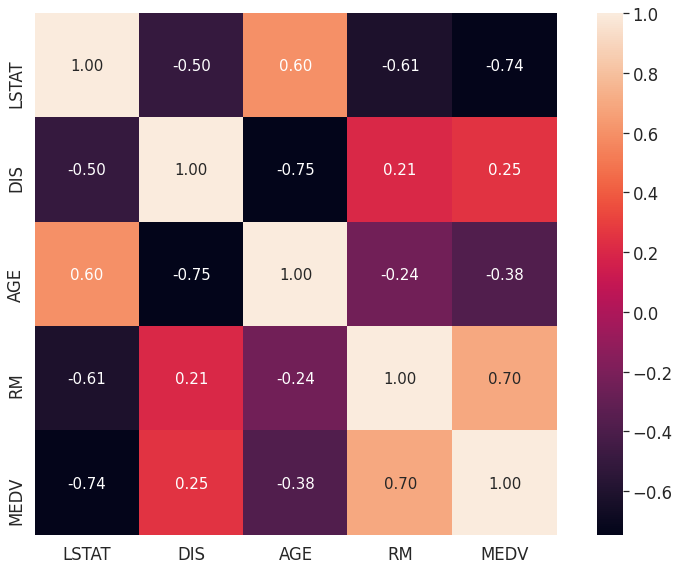

In [17]:
import numpy as np
import seaborn as sns
cols = ['LSTAT', 'DIS', 'AGE', 'RM', 'MEDV']
cm = np.corrcoef(df_boston[cols].values.T)
sns.set(font_scale = 1.5, rc={'figure.figsize':(11.7,8.27)})
hm = sns.heatmap(cm, 
                 cbar = True, 
                 annot = True, 
                 square = True, 
                 fmt = '.2f', 
                 annot_kws = {'size':15}, 
                 yticklabels=cols, 
                 xticklabels=cols)
plt.tight_layout()
plt.show()

- 위 결과값이 무엇을 의미할까?
- 만약 `MEDV`를 제외한 4개의 변수 중 2개의 변수만 추출해야 한다면, 상관성이 높은 `LSTAT`와 `RM`의 변수를 선택하는 것이 좋다. 


### (3) Sklearn 회귀모형
- `LinearRegression` 클래스
  + `LinearRegression` 클래스는 예측값과 실제 값의 RSS(Residual Sum of Squares)를 최소화해 `OLS(Ordinary Least Squares)` 추정 방식으로 구현한 클래스다. 
- 입력 파라미터
  + fit_intercept: intercept(절편) 값을 계산할 것인지 말지를 지정한다. 
  + normalize: 만약 `True`이면, 입력 데이터 세트를 정규화 한다. 
- 속성
  + coef_: `fit()` 메서드를 수행했을 때, 회귀 계수가 배열 형태로 저장하는 속성.
- 회귀 모형 시에는 다중공선성(`Multi-collinearity`) 문제가 발생할 수 있다. 


### (4) 회귀 평가 지표
- 회귀 평가 지표는 일반적인 통계모형의 적합성 평가, 결정계수 등과 다르다. 
- 머신러닝에서는 예측 지표가 우선이다. 
  + 실제 값과 회귀 예측값의 차이 값을 기반으로 한 지표가 중심이다.
  + 회귀의 성능을 평가하는 지표는 다음과 같다. 
- MAE(Mean Absolute Error): 실제 값과 예측값의 차이를 절대값으로 변환해 평균
- MSE(Mean Squared Error): 실제 값과 예측값의 차이를 제곱해 평균
- RMSE(Root Mean Squared Error): `MSE`값은 오류의 제곱을 구하며, 실제 오류 평균보다 더 커지는 특성이 있어서 `MSE`에 `Root`를 쒸움
- $R^2$는 분산 기반으로 예측 성능을 평가 하고, 실제 값의 분산대비 예측값의 분산 비율을 지표로 하기 때문에, 1에 가까울수록 예측 정확도가 높다. 
- `sklearn.metrics`에는 `MAE`, `MSE`, $R^2$가 있다, `RMSE`는 존재하지 않기 때문에 `MSE`에 `Root`를 씌워준다.   


## III. 실습
- 이제 훈련 및 테스트데이터를 만들어 예측 모형을 만들어본다. 

### (1) 데이터셋 분리
- 훈련 및 테스트 데이터를 분리한다. 

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 종속변수 및 독립변수 데이터 셋으로 분리
y_target = df_boston['MEDV']
X_data = df_boston.drop(['MEDV'], axis = 1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((354, 13), (152, 13), (354,), (152,))

- 마지막 줄 `shape`를 습관적으로 해주는 것이 좋다. 
  + 데이터의 행과 열이 일치하는지 확인한다. 


### (2) 회귀 모형 만들기
- 이제 모형을 만들어본다. 

In [21]:
my_1st_lr = LinearRegression()
my_1st_lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### (3) 모형 예측
- `predict()` 함수를 활용해서 `X_test`를 실행한다. 


In [22]:
y_preds = my_1st_lr.predict(X_test)
y_preds[0:5]

array([32.3914647 , 27.94401279, 17.83762764, 21.66941388, 18.93639614])

- `0:5` 예측값에 대한 결과가 나온다. 


### (4) 회귀 계수
- 이번에는 절편 및 회귀 계수값을 구해본다. 
- 이 회귀 계수는 각 변수에 대한 회귀 계수를 의미한다. 

In [23]:
print("절편:", my_1st_lr.intercept_)
print('회귀 계수:', np.round(my_1st_lr.coef_, 1))

절편: 46.39649387182328
회귀 계수: [ -0.1   0.1   0.1   2.4 -21.5   2.8   0.   -1.5   0.3  -0.   -1.    0.
  -0.6]


- 이번에는 회귀 계수가 큰 값 순으로 정렬한다. 이 때, 각 변수를 매칭 시켜서 중요 요인을 확인해본다. 

In [24]:
coef_df = pd.Series(data=np.round(my_1st_lr.coef_, 1), index = X_data.columns)
coef_df.sort_values(ascending=False)

RM          2.8
CHAS        2.4
RAD         0.3
INDUS       0.1
ZN          0.1
B           0.0
TAX        -0.0
AGE         0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -1.0
DIS        -1.5
NOX       -21.5
dtype: float64

- 위 결과에서 보는 것처럼, `RM`과 `NOX`에서 회귀 계수 값이 가장 큰 것으로 나타났으며, 이는 `MEDV` 가격 형성에 매우 중요한 요소임을 확인할 수 있다. 

### (5) 모형 평가
- 회귀 모형에 대한 평가를 진행해본다. 
- `RMSE`는 없기 때문에, 새로 만들어야 한다. 

In [25]:
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
r2_points = r2_score(y_test, y_preds)
print("RMSE:", rmse)
print("R^2:", r2_points)

RMSE: 4.4532374371981245
R^2: 0.7836295385076315


## IV. 결론
- 지금까지 진행 한 것은 회귀모형에 대한 이해를 위한 것이며, 실제로는 위와 같이 선형 회귀 모형 1개만을 만들지 않는다. 
  + 특히 회귀 계수는 선형 회귀에만 나오는 개념이며, 나무모형, SVM은 또 다르다. 
  + 그럼 각각 일일이 다 공부하는 게 의미가 있는 것인가?
  + 모든 통계 모형을 한꺼번에 다 공부하는 것은 `지양`한다. 
    * 시간이 해결해준다. 그리고, 최신 논문을 늘 챙긴다. 
  + 이제 나무 모형으로 넘어간다. 현재 나오는 최신 알고리즘은 나무 모형에 기반하기 때문이다. 
- 이 때, 우리가 기억해야 하는 것은 모형의 평가다. 
  + 예측에서 중요한 것은 예측값과 실제값의 오차를 줄이는 것. 이것만 기억하자. 